In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 문제
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 17,8

import warnings
warnings.filterwarnings(action='ignore')

# **대구 교통 사고 피해 예측 AI 경진대회 Baseline Code**

## **Fixed Random Seed**  

seed 값에 의해 동일한 코드를 사용해도 결과가 다를 수 있기에, 동일한 결과를 위해 seed 값을 고정시킵니다

In [2]:
import os
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## **데이터 불러오기 및 상위행 확인**  

train.csv, test.csv 파일을 로드하여 상위행을 출력해 봅시다

In [3]:
import pandas as pd
from datetime import datetime

train = pd.read_csv('./open/train.csv', encoding = "utf-8", low_memory=False)
test = pd.read_csv('./open/test.csv', encoding = "utf-8", low_memory=False)


## **train, test 데이터 기간 확인하기**  

학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 봅니다

In [4]:
display(f"train : {train.iloc[0]['사고일시']} ~ {train.iloc[-1]['사고일시']}")
display(f"test : {test.iloc[0]['사고일시']} ~ {test.iloc[-1]['사고일시']}")

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

### Data Info

In [5]:
#'사고일시' 데이터 타입을 object -> datetime으로  바꾸기
train['사고일시'] = pd.to_datetime(train['사고일시'])
test['사고일시'] = pd.to_datetime(test['사고일시'])

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           39609 non-null  object        
 1   사고일시         39609 non-null  datetime64[ns]
 2   요일           39609 non-null  object        
 3   기상상태         39609 non-null  object        
 4   시군구          39609 non-null  object        
 5   도로형태         39609 non-null  object        
 6   노면상태         39609 non-null  object        
 7   사고유형         39609 non-null  object        
 8   사고유형 - 세부분류  39609 non-null  object        
 9   법규위반         39609 non-null  object        
 10  가해운전자 차종     39609 non-null  object        
 11  가해운전자 성별     39609 non-null  object        
 12  가해운전자 연령     39609 non-null  object        
 13  가해운전자 상해정도   39609 non-null  object        
 14  피해운전자 차종     38618 non-null  object        
 15  피해운전자 성별     38618 non-null  object        
 16  피해운전

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ID      10963 non-null  object        
 1   사고일시    10963 non-null  datetime64[ns]
 2   요일      10963 non-null  object        
 3   기상상태    10963 non-null  object        
 4   시군구     10963 non-null  object        
 5   도로형태    10963 non-null  object        
 6   노면상태    10963 non-null  object        
 7   사고유형    10963 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 685.3+ KB


### - train과 test 데이터셋의  컬럼 수가 서로 다름
    - ID, 사고일시, 요일, 기상상태, 시군구, 도로형태, 노면상태, 사고유형

In [8]:
display(train['요일'].unique())
display(test['요일'].unique())

array(['화요일', '수요일', '목요일', '금요일', '토요일', '일요일', '월요일'], dtype=object)

array(['토요일', '일요일', '월요일', '화요일', '수요일', '목요일', '금요일'], dtype=object)

In [9]:
display(train['기상상태'].unique())
display(test['기상상태'].unique())

array(['맑음', '흐림', '기타', '비', '안개', '눈'], dtype=object)

array(['맑음', '흐림', '기타', '비', '눈'], dtype=object)

***- test에는 기상상태-'안개' 없음***

In [10]:
# display(train['시군구'].unique())
# display(test['시군구'].unique())

In [11]:
# display(train['도로형태'].unique())
# display(test['도로형태'].unique())

In [12]:
# display(train['노면상태'].unique())
# display(test['노면상태'].unique())

In [13]:
# display(train['사고유형'].unique())
# display(test['사고유형'].unique())

## **데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다  

## **파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [14]:
import pandas as pd
from datetime import datetime
# 최초에 불러온 데이터가 train, test이고 이 두개가 날짜데이터 파싱한것이기 때문에 이 데이터를 원본으로 데이터전처리.
# train_org = pd.read_csv('./open/train.csv',encoding = "utf-8", low_memory=False)
# test_org = pd.read_csv('./open/test.csv', encoding = "utf-8", low_memory=False)

In [15]:
print(train['사고일시'].dtype)

datetime64[ns]


In [16]:
train_df = train.copy()
test_df = test.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'
train['사고일시'] = train['사고일시'].astype(str)
train_df[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test['사고일시'] = test['사고일시'].astype(str)
test_df[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

## **파생 변수 생성 2 : 공간(위치) 정보 생성**

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환 합니다

In [17]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

## **파생 변수 추출 3 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [18]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

## train, test 컬럼 수 맞추기

test에 있는 컬럼들만 사용하여 train 데이터를 구성했습니다.

In [19]:
train_df= train_df[['ID','요일','기상상태','노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구','동', '도로형태1', '도로형태2']]
train_df

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,2019,1,1,4,대구광역시,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,2021,12,31,22,대구광역시,달서구,장동,기타,기타


## **전처리 결과 확인**

지금까지 전처리한 결과를 확인해 봅시다

In [20]:
display(train_df.head())
display(test_df.head())

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,2019,1,1,4,대구광역시,동구,신암동,단일로,기타


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안


## 데이터 초기화 (data_label_enco, data_onehot_enco)

In [21]:
# 전처리를 위해 train과 test 데이터를 data라는 데이터프레임으로 합치기
data = pd.concat([train_df, test_df], sort=False)
data_label_enco = data.copy()
data_onehot_enco = data.copy()

# **1. 노면상태, 사고유형 엔코딩**

## Label encoding

In [22]:
from sklearn.preprocessing import LabelEncoder
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# "사고유형" 컬럼 Label Encoding
data_label_enco['사고유형'] = label_encoder.fit_transform(data_label_enco['사고유형'])

# "노면상태" 컬럼 Label Encoding
data_label_enco['노면상태'] = label_encoder.fit_transform(data_label_enco['노면상태'])

# 결과 확인
print(data_label_enco[['사고유형', '노면상태']])
data_label_enco.info()

       사고유형  노면상태
0         0     0
1         0     0
2         0     0
3         1     0
4         1     0
...     ...   ...
10958     1     0
10959     1     0
10960     1     0
10961     1     0
10962     1     0

[50572 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   요일      50572 non-null  object
 2   기상상태    50572 non-null  object
 3   노면상태    50572 non-null  int64 
 4   사고유형    50572 non-null  int64 
 5   연       50572 non-null  int64 
 6   월       50572 non-null  int64 
 7   일       50572 non-null  int64 
 8   시간      50572 non-null  int64 
 9   도시      50572 non-null  object
 10  구       50572 non-null  object
 11  동       50572 non-null  object
 12  도로형태1   50572 non-null  object
 13  도로형태2   50572 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.8+ MB


## One-Hot Encoding

In [23]:
# "사고유형" 및 "노면상태" 컬럼을 원-핫 인코딩
data_onehot_enco = pd.get_dummies(data, columns=['사고유형', '노면상태'])

## 전처리한 데이터로 선형회귀 및 rmsle확인

# **------------------------------------------------------**

# **2. 도로유형 인코딩**

### 라벨인코딩 - 도로유형1

In [24]:
le = LabelEncoder()
le.fit(data_label_enco['도로형태1'])

LabelEncoder()

In [25]:
le.transform(data_label_enco['도로형태1'])

array([2, 2, 2, ..., 2, 0, 0])

In [26]:
label_data = data.copy()

In [27]:
data_label_enco['도로형태1'] = le.transform(data_label_enco['도로형태1'])

In [28]:
data_label_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   요일      50572 non-null  object
 2   기상상태    50572 non-null  object
 3   노면상태    50572 non-null  int64 
 4   사고유형    50572 non-null  int64 
 5   연       50572 non-null  int64 
 6   월       50572 non-null  int64 
 7   일       50572 non-null  int64 
 8   시간      50572 non-null  int64 
 9   도시      50572 non-null  object
 10  구       50572 non-null  object
 11  동       50572 non-null  object
 12  도로형태1   50572 non-null  int64 
 13  도로형태2   50572 non-null  object
dtypes: int64(7), object(7)
memory usage: 5.8+ MB


### 라벨인코딩 - 도로유형2

In [29]:
le = LabelEncoder()
le.fit(data_label_enco['도로형태2'])
le.transform(data_label_enco['도로형태2'])

data_label_enco['도로형태2'] = le.transform(data_label_enco['도로형태2'])

data_label_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   요일      50572 non-null  object
 2   기상상태    50572 non-null  object
 3   노면상태    50572 non-null  int64 
 4   사고유형    50572 non-null  int64 
 5   연       50572 non-null  int64 
 6   월       50572 non-null  int64 
 7   일       50572 non-null  int64 
 8   시간      50572 non-null  int64 
 9   도시      50572 non-null  object
 10  구       50572 non-null  object
 11  동       50572 non-null  object
 12  도로형태1   50572 non-null  int64 
 13  도로형태2   50572 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 5.8+ MB


### 원핫인코딩 - 도로형태1

In [30]:
from sklearn.preprocessing import OneHotEncoder

data_onehot_enco = pd.get_dummies(data_onehot_enco, columns=['도로형태1', '도로형태2'])

In [31]:
data_onehot_enco.info()
# oe_road1 = pd.DataFrame(oe_road1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   요일               50572 non-null  object
 2   기상상태             50572 non-null  object
 3   연                50572 non-null  int64 
 4   월                50572 non-null  int64 
 5   일                50572 non-null  int64 
 6   시간               50572 non-null  int64 
 7   도시               50572 non-null  object
 8   구                50572 non-null  object
 9   동                50572 non-null  object
 10  사고유형_차대사람        50572 non-null  uint8 
 11  사고유형_차대차         50572 non-null  uint8 
 12  사고유형_차량단독        50572 non-null  uint8 
 13  노면상태_건조          50572 non-null  uint8 
 14  노면상태_기타          50572 non-null  uint8 
 15  노면상태_서리/결빙       50572 non-null  uint8 
 16  노면상태_적설          50572 non-null  uint8 
 17  노면상태_젖음/습기       50572 non-null

In [32]:

# data_onehot_enco = pd.merge(data, oe_road1, left_index=True, right_index=True)

# data_onehot_enco = data_onehot_enco.drop(columns='도로형태1')
# data_onehot_enco = data_onehot_enco.rename(columns= {0 : '도로형태1'})

# data_onehot_enco.info()

### 원핫인코딩 - 도로형태2 -> (수정) : 위에서 한번에 data_onehot_enco에 값입력

In [33]:

# le = LabelEncoder()
# oe = OneHotEncoder()

# le.fit(data['도로형태2'])
# road2 = le.transform(data['도로형태2'])
# road2 = road2.reshape(-1, 1)

# oe.fit(road2)
# oe_road2 = oe.transform(road2)


# oe_road2 = pd.DataFrame(oe_road2)


# data_label_enco = pd.merge(data_label_enco, oe_road2, left_index=True, right_index=True)

# data_label_enco = one_hot.drop(columns='도로형태2')
# data_label_enco = one_hot.rename(columns= {0 : '도로형태2'})

# data_label_enco.info()

In [34]:
# one_hot = pd.get_dummies(data, columns=['도로형태1', '도로형태2'])
# one_hot

# **------------------------------------------------------**

# **3. 구,동 인코딩**

In [35]:
# data = pd.concat([train_df, test_df], sort=False)

## **원-핫 인코딩 적용**

### 구
- `ohe_gu` : 원-핫 인코딩 적용된 배열
- `ohe_gu_df` : `ohe_gu` 의 df

**1. 구 정보 확인**

In [36]:
label_gu = data['구']
print(label_gu.unique())
print(label_gu.shape)
data.info()

['중구' '달서구' '수성구' '북구' '동구' '서구' '달성군' '남구']
(50572,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   요일      50572 non-null  object
 2   기상상태    50572 non-null  object
 3   노면상태    50572 non-null  object
 4   사고유형    50572 non-null  object
 5   연       50572 non-null  int64 
 6   월       50572 non-null  int64 
 7   일       50572 non-null  int64 
 8   시간      50572 non-null  int64 
 9   도시      50572 non-null  object
 10  구       50572 non-null  object
 11  동       50572 non-null  object
 12  도로형태1   50572 non-null  object
 13  도로형태2   50572 non-null  object
dtypes: int64(4), object(10)
memory usage: 5.8+ MB


**2. 원-핫 인코딩 적용**

In [37]:
# 1. OneHotEncoder 임포트 및 정의
ohe = OneHotEncoder(sparse=False) # array 반환을 위해 sparse=False

# 2. 2차원 데이터로 반환
label_gu_rs = label_gu.values.reshape(-1, 1)

# 3. One-Hot Encoding 적용
ohe.fit(label_gu_rs)

# 4. One-Hot Encoding 적용된 배열 리턴
ohe_gu = ohe.transform(label_gu_rs)

In [38]:
print('One-Hot Encoding 적용된 배열: ', ohe_gu)
print('One-Hot Encoding 카테고리 확인: ', ohe.categories_)

One-Hot Encoding 적용된 배열:  [[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
One-Hot Encoding 카테고리 확인:  [array(['남구', '달서구', '달성군', '동구', '북구', '서구', '수성구', '중구'], dtype=object)]


In [39]:
ohe_gu_df = pd.DataFrame(ohe_gu, columns=ohe.categories_[0])
ohe_gu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50572 entries, 0 to 50571
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   남구      50572 non-null  float64
 1   달서구     50572 non-null  float64
 2   달성군     50572 non-null  float64
 3   동구      50572 non-null  float64
 4   북구      50572 non-null  float64
 5   서구      50572 non-null  float64
 6   수성구     50572 non-null  float64
 7   중구      50572 non-null  float64
dtypes: float64(8)
memory usage: 3.1 MB


## merge할때 새로 적은 코드-구 데이터 원핫인코딩-

In [40]:
data_onehot_enco = pd.get_dummies(data_onehot_enco, columns=['구'])
data_onehot_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   요일               50572 non-null  object
 2   기상상태             50572 non-null  object
 3   연                50572 non-null  int64 
 4   월                50572 non-null  int64 
 5   일                50572 non-null  int64 
 6   시간               50572 non-null  int64 
 7   도시               50572 non-null  object
 8   동                50572 non-null  object
 9   사고유형_차대사람        50572 non-null  uint8 
 10  사고유형_차대차         50572 non-null  uint8 
 11  사고유형_차량단독        50572 non-null  uint8 
 12  노면상태_건조          50572 non-null  uint8 
 13  노면상태_기타          50572 non-null  uint8 
 14  노면상태_서리/결빙       50572 non-null  uint8 
 15  노면상태_적설          50572 non-null  uint8 
 16  노면상태_젖음/습기       50572 non-null  uint8 
 17  노면상태_침수          50572 non-null

### 동
- `ohe_dong` : 원-핫 인코딩 적용된 배열
- `ohe_dong_df` : ohe_dong 의 df

**1. 동 정보 확인**

In [41]:
label_dong = data['동']
print(label_dong.unique())
print(label_dong.shape)

['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송현동' '고성동3가' '봉덕동' '칠성동2가' '공평동'
 '봉산동' '괴전동' '국우동' '대현동' '노원동1가' '대봉동' '본동' '신서동' '검단동' '화원읍' '동호동'
 '삼덕동2가' '입석동' '중동' '삼덕동3가' '파호동' '동내동' '하빈면' '율암동' '동인동1가' '내당동' '유천동'
 '호산동' '교동' '옥포읍' '원대동3가' '검사동' '동인동4가' '수성동1가' '고성동2가' '각산동' '중리동'
 '고성동1가' '갈산동' '대림동' '호림동' '연호동' '동변동' '범물동' '계산동2가' '동문동' '고모동' '금호동'
 '장동' '도원동' '수창동' '동인동2가' '가천동' '노변동' '달성동' '동인동3가' '서문로2가' '동성로2가' '중대동'
 '사월동' '장관동' '신평동' '숙천동' '성동' '동일동' '시장북로' '서호동' '용수동' '대흥동' '동성로3가' '연경동'
 '원대동1가' '남일동' '부동' '송정동' '백안동' '도동' '인교동' '미대동' '노원동2가' '북성로1가

**2. 원-핫 인코딩 적용**

In [42]:
# # 1. OneHotEncoder 임포트 및 정의
# ohe = OneHotEncoder(sparse=False) # array 반환을 위해 sparse=False

# # 2. 2차원 데이터로 반환
# label_dong_rs = label_dong.values.reshape(-1, 1)

# # 3. One-Hot Encoding 적용
# ohe.fit(label_dong_rs)

# # 4. One-Hot Encoding 적용된 배열 리턴
# ohe_dong = ohe.transform(label_dong_rs)

In [43]:
# print('One-Hot Encoding 적용된 배열: ', ohe_dong)
# print('One-Hot Encoding 카테고리 확인: ', ohe.categories_)

In [44]:
# ohe_dong_df = pd.DataFrame(ohe_dong, columns=ohe.categories_[0])
# ohe_dong_df

## merge할때 새로 적은 코드 - 동 데이터 원핫인코딩-

In [45]:
# data_onehot_enco = pd.get_dummies(data_onehot_enco, columns=['동'])
# data_onehot_enco.info()

## 구,동 레이블 인코딩 적용

### 구
- `le_gu` : 레이블 인코딩 적용된 배열
- `le_gu_df` : `le_gu` 의 df

In [46]:
from sklearn.preprocessing import LabelEncoder

**1. 구 정보 확인**

In [47]:
label_gu = data['구']
print(label_gu.unique())
print(label_gu.shape)

['중구' '달서구' '수성구' '북구' '동구' '서구' '달성군' '남구']
(50572,)


**2. 레이블 인코딩 적용**

In [48]:
# 1. LabelEncoder 임포트 및 정의
le = LabelEncoder()

# 2. 2차원 데이터로 반환
label_gu_rs = label_gu.values.reshape(-1, 1)

# 2. LabelEncoder 적용
le_gu = le.fit_transform(label_gu_rs)

### 라벨인코딩 기존 코드에서 작업하기위해 추가한 코드

In [49]:
label_encoder_gu = LabelEncoder()

# "사고유형" 컬럼 Label Encoding
data_label_enco['구'] = label_encoder_gu.fit_transform(data['구'])

# "노면상태" 컬럼 Label Encoding
data_label_enco['구'] = label_encoder_gu.fit_transform(data['구'])

# 결과 확인
data_label_enco.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   요일      50572 non-null  object
 2   기상상태    50572 non-null  object
 3   노면상태    50572 non-null  int64 
 4   사고유형    50572 non-null  int64 
 5   연       50572 non-null  int64 
 6   월       50572 non-null  int64 
 7   일       50572 non-null  int64 
 8   시간      50572 non-null  int64 
 9   도시      50572 non-null  object
 10  구       50572 non-null  int64 
 11  동       50572 non-null  object
 12  도로형태1   50572 non-null  int64 
 13  도로형태2   50572 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 5.8+ MB


In [50]:
print(set(le_gu))
print(le.classes_)
print(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))

{0, 1, 2, 3, 4, 5, 6, 7}
['남구' '달서구' '달성군' '동구' '북구' '서구' '수성구' '중구']
['남구' '달서구' '달성군' '동구' '북구' '서구' '수성구' '중구']


In [51]:
le_gu_df = pd.DataFrame(le_gu, columns=['구'])
le_gu_df

,구
0,7
1,1
2,6
3,4
4,3
...,...
50567,0
50568,6
50569,6
50570,6


### 동
- `le_dong` : 레이블 인코딩 적용된 배열
- `le_dong_df` : le_dong 의 df

**1. 동 정보 확인**

In [52]:
label_dong = data['동']
print(label_dong.unique())
print(label_dong.shape)

['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송현동' '고성동3가' '봉덕동' '칠성동2가' '공평동'
 '봉산동' '괴전동' '국우동' '대현동' '노원동1가' '대봉동' '본동' '신서동' '검단동' '화원읍' '동호동'
 '삼덕동2가' '입석동' '중동' '삼덕동3가' '파호동' '동내동' '하빈면' '율암동' '동인동1가' '내당동' '유천동'
 '호산동' '교동' '옥포읍' '원대동3가' '검사동' '동인동4가' '수성동1가' '고성동2가' '각산동' '중리동'
 '고성동1가' '갈산동' '대림동' '호림동' '연호동' '동변동' '범물동' '계산동2가' '동문동' '고모동' '금호동'
 '장동' '도원동' '수창동' '동인동2가' '가천동' '노변동' '달성동' '동인동3가' '서문로2가' '동성로2가' '중대동'
 '사월동' '장관동' '신평동' '숙천동' '성동' '동일동' '시장북로' '서호동' '용수동' '대흥동' '동성로3가' '연경동'
 '원대동1가' '남일동' '부동' '송정동' '백안동' '도동' '인교동' '미대동' '노원동2가' '북성로1가

**2. 레이블 인코딩 적용**

### 라벨인코딩 기존 코드에서 작업하기위해 추가한 코드

In [53]:
label_encoder_gu = LabelEncoder()

# "사고유형" 컬럼 Label Encoding
data_label_enco['동'] = label_encoder_gu.fit_transform(data['동'])

# "노면상태" 컬럼 Label Encoding
data_label_enco['동'] = label_encoder_gu.fit_transform(data['동'])

# 결과 확인
data_label_enco.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   요일      50572 non-null  object
 2   기상상태    50572 non-null  object
 3   노면상태    50572 non-null  int64 
 4   사고유형    50572 non-null  int64 
 5   연       50572 non-null  int64 
 6   월       50572 non-null  int64 
 7   일       50572 non-null  int64 
 8   시간      50572 non-null  int64 
 9   도시      50572 non-null  object
 10  구       50572 non-null  int64 
 11  동       50572 non-null  int64 
 12  도로형태1   50572 non-null  int64 
 13  도로형태2   50572 non-null  int64 
dtypes: int64(10), object(4)
memory usage: 5.8+ MB


In [54]:
# 1. LabelEncoder 임포트 및 정의
le = LabelEncoder()

# 2. 2차원 데이터로 반환
label_dong_rs = label_dong.values.reshape(-1, 1)

# 2. LabelEncoder 적용
le_dong = le.fit_transform(label_dong_rs)
print(set(le_dong))
print(le.classes_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195}
['가창면' '가천동' '각산동' '갈산동' '감삼동' '검단동' '검사동' '계산동1가' '계산동2가' '고모동' '고성동1가'
 '고성동2가' '고성동3가' '공평동' '관음동' '괴전동' '교동' '구암동' '구지면' '국우동

In [55]:
le_dong_df = pd.DataFrame(le_dong, columns=['동'])
le_dong_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50572 entries, 0 to 50571
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   동       50572 non-null  int64
dtypes: int64(1)
memory usage: 395.2 KB


# **------------------------------------------------------**

# **4. 연,월,시 원핫인코딩**


#### 연,월,(일), 시간 최빈값 알아보기

In [56]:
#최빈값 알아보기
data['연'].value_counts().sort_index()

2019    14536
2020    12940
2021    12133
2022    10963
Name: 연, dtype: int64

In [57]:
train_df['월'].value_counts()

10    3666
11    3577
5     3474
9     3413
6     3407
7     3381
8     3300
12    3262
4     3251
3     3052
1     3030
2     2796
Name: 월, dtype: int64

In [58]:
data['월'].value_counts()

10    4638
11    4599
5     4514
9     4366
7     4364
6     4339
4     4186
8     4168
12    4142
1     3904
3     3848
2     3504
Name: 월, dtype: int64

In [59]:
data['일'].value_counts()

11    1736
21    1728
8     1724
14    1717
27    1705
9     1700
4     1688
7     1685
18    1677
28    1676
10    1671
22    1671
15    1666
23    1665
20    1662
26    1657
24    1649
29    1647
17    1644
6     1639
25    1637
13    1635
16    1632
3     1631
12    1629
5     1618
2     1617
19    1569
30    1544
1     1544
31     909
Name: 일, dtype: int64

### Chatpgt의 대답

Label Encoding: 순서나 순위가 있는 경우에 사용됩니다. 하지만, 년도는 연도 간의 순서를 나타내는 정량적인 정보보다는 범주형 정보로 인식하는 것이 더 적절합니다. Label Encoding은 연도 간의 관계를 숫자로 나타내기 때문에 모델이 연도 사이의 순서를 잘못 이해할 수 있습니다.

One-Hot Encoding: 각 연도를 별도의 피처로 인식하여 2019, 2020, 2021, 2022와 같이 각 연도를 0 또는 1로 표현하는 것입니다. 연도 간의 순서를 고려하지 않고 각각 독립된 피처로 다루기 때문에 모델이 연도 사이의 관계를 잘 파악할 수 있습니다. 또한, 연도 간의 교통사고 발생량의 변화를 모델이 명확히 이해할 수 있습니다.

주어진 상황에서는 교통사고 발생량의 추세와 관련이 있으므로, One-Hot Encoding을 사용하여 각 연도를 독립된 피처로 다루는 것이 더 적절할 것 같아요. 이렇게 하면 모델이 각 연도의 교통사고 발생량에 대한 패턴을 잘 파악할 수 있어요.

In [60]:
# 연도의 one-hot encoding 및 확인
data_onehot_enco = pd.get_dummies(data_onehot_enco, columns=['연'])

In [61]:
data_onehot_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   요일               50572 non-null  object
 2   기상상태             50572 non-null  object
 3   월                50572 non-null  int64 
 4   일                50572 non-null  int64 
 5   시간               50572 non-null  int64 
 6   도시               50572 non-null  object
 7   동                50572 non-null  object
 8   사고유형_차대사람        50572 non-null  uint8 
 9   사고유형_차대차         50572 non-null  uint8 
 10  사고유형_차량단독        50572 non-null  uint8 
 11  노면상태_건조          50572 non-null  uint8 
 12  노면상태_기타          50572 non-null  uint8 
 13  노면상태_서리/결빙       50572 non-null  uint8 
 14  노면상태_적설          50572 non-null  uint8 
 15  노면상태_젖음/습기       50572 non-null  uint8 
 16  노면상태_침수          50572 non-null  uint8 
 17  도로형태1_교차로        50572 non-null

In [62]:
# 월의 one-hot encoding 및 확인
data_onehot_enco = pd.get_dummies(data_onehot_enco, columns=['월'])
data_onehot_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   요일               50572 non-null  object
 2   기상상태             50572 non-null  object
 3   일                50572 non-null  int64 
 4   시간               50572 non-null  int64 
 5   도시               50572 non-null  object
 6   동                50572 non-null  object
 7   사고유형_차대사람        50572 non-null  uint8 
 8   사고유형_차대차         50572 non-null  uint8 
 9   사고유형_차량단독        50572 non-null  uint8 
 10  노면상태_건조          50572 non-null  uint8 
 11  노면상태_기타          50572 non-null  uint8 
 12  노면상태_서리/결빙       50572 non-null  uint8 
 13  노면상태_적설          50572 non-null  uint8 
 14  노면상태_젖음/습기       50572 non-null  uint8 
 15  노면상태_침수          50572 non-null  uint8 
 16  도로형태1_교차로        50572 non-null  uint8 
 17  도로형태1_기타         50572 non-null

In [63]:
# 시간의 one-hot encoding 및 확인
data_onehot_enco = pd.get_dummies(data_onehot_enco, columns=['시간'])
data_onehot_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   요일               50572 non-null  object
 2   기상상태             50572 non-null  object
 3   일                50572 non-null  int64 
 4   도시               50572 non-null  object
 5   동                50572 non-null  object
 6   사고유형_차대사람        50572 non-null  uint8 
 7   사고유형_차대차         50572 non-null  uint8 
 8   사고유형_차량단독        50572 non-null  uint8 
 9   노면상태_건조          50572 non-null  uint8 
 10  노면상태_기타          50572 non-null  uint8 
 11  노면상태_서리/결빙       50572 non-null  uint8 
 12  노면상태_적설          50572 non-null  uint8 
 13  노면상태_젖음/습기       50572 non-null  uint8 
 14  노면상태_침수          50572 non-null  uint8 
 15  도로형태1_교차로        50572 non-null  uint8 
 16  도로형태1_기타         50572 non-null  uint8 
 17  도로형태1_단일로        50572 non-null

이미 연도, 월, 시간은 숫자형 데이터로 되어 있기 때문에 Label Encoding을 하는 것은 좋지 않은 선택일 수 있습니다. Label Encoding은 주로 문자열 형태의 범주형 데이터를 숫자로 변환할 때 사용됩니다. 숫자형 데이터에 Label Encoding을 적용하면 모델이 해당 데이터를 범주형이라고 오해할 수 있고, 연속된 숫자 값의 크기를 고려할 수 있어 잘못된 학습을 유발할 수 있습니다.

따라서 이미 숫자로 표현된 연도, 월, 시간 데이터에 대해서는 Label Encoding을 적용할 필요가 없습니다. 이러한 경우에는 따로 전처리를 하지 않고 그대로 사용하는 것이 모델에 더 적합할 수 있습니다. 만약 이러한 데이터를 카테고리형 변수로 사용하고자 한다면, 해당 컬럼들을 One-Hot Encoding 등 다른 방법으로 처리하는 것이 좋을 수 있어요.

# **------------------------------------------------------**

# **5. 요일, 기상 엔코딩**

## Case 1: '요일' 컬럼 LabelEncoding
**0 = 금요일 / 1 = 목요일 / 2 = 수요일 / 3 = 월요일 / 4 = 일요일 / 5 = 토요일 / 6 = 화요일**로 변환됨

인코딩된 값 삽입위해 기존 '요일'컬럼 삭제

In [64]:
data_label_enco = data_label_enco.drop(data_label_enco.columns[1], axis=1).copy()

**요일 컬럼 LabelEncoding 후 컬럼 순서 다시 정렬**

In [65]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['요일'])
data_label_enco['요일'] = encoder.transform(data['요일'])
data_label_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   기상상태    50572 non-null  object
 2   노면상태    50572 non-null  int64 
 3   사고유형    50572 non-null  int64 
 4   연       50572 non-null  int64 
 5   월       50572 non-null  int64 
 6   일       50572 non-null  int64 
 7   시간      50572 non-null  int64 
 8   도시      50572 non-null  object
 9   구       50572 non-null  int64 
 10  동       50572 non-null  int64 
 11  도로형태1   50572 non-null  int64 
 12  도로형태2   50572 non-null  int64 
 13  요일      50572 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 5.8+ MB


**가독성 위해 컬럼 순서 원래 순서와 맞춰 정렬**

In [66]:
data_label_enco = data_label_enco[['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2']]
display(data_label_enco.head())
print('인코딩 변환값 :', set(data_label_enco['요일']))

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,6,맑음,0,0,2019,1,1,0,대구광역시,7,40,2,5
1,ACCIDENT_00001,6,흐림,0,0,2019,1,1,0,대구광역시,1,4,2,5
2,ACCIDENT_00002,6,맑음,0,0,2019,1,1,1,대구광역시,6,66,2,5
3,ACCIDENT_00003,6,맑음,0,1,2019,1,1,2,대구광역시,4,79,2,5
4,ACCIDENT_00004,6,맑음,0,1,2019,1,1,4,대구광역시,3,129,2,5


인코딩 변환값 : {0, 1, 2, 3, 4, 5, 6}


## Case 2 : 요일 컬럼 One-hot 인코딩 진행하기
- LabelEncoding 진행 시, 숫자값의 크고 작음이 있기에 몇몇 ML에서의 예측 성능이 떨어질 수 있음
- 그 이유로는 범주형 데이터를 수치형 데이터로만 변환을 하게 되면 **서로 간의 관계성**이 생기기 때문
- 예를 들어, 월요일을 1, 화요일을 2, 수요이을 3이라고 단순하게 수치형 데이터로 변환하게 되면 **해당 데이터들 간 1+2 = 3 이라는 관계성**이 존재하게 되는 문제가 있다
- **단, Tree 계열의 ML은 숫자의 이러한 특성을 반영하지 않으므로 괜찮다고 함**
- 위의 문제점을 방지하고자 요일 컬럼을 **one-hot 인코딩 방식인 get_dummies 방식**을 진행함

### **One-Hot 인코딩 결과**
해당 요일에 맞게 0과 1로 구성된 더미값들을 만듬

In [67]:
# data_onehot_enco.info()

In [68]:
data_onehot_enco = pd.get_dummies(data_onehot_enco, columns=['요일'])
data_onehot_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 84 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   기상상태             50572 non-null  object
 2   일                50572 non-null  int64 
 3   도시               50572 non-null  object
 4   동                50572 non-null  object
 5   사고유형_차대사람        50572 non-null  uint8 
 6   사고유형_차대차         50572 non-null  uint8 
 7   사고유형_차량단독        50572 non-null  uint8 
 8   노면상태_건조          50572 non-null  uint8 
 9   노면상태_기타          50572 non-null  uint8 
 10  노면상태_서리/결빙       50572 non-null  uint8 
 11  노면상태_적설          50572 non-null  uint8 
 12  노면상태_젖음/습기       50572 non-null  uint8 
 13  노면상태_침수          50572 non-null  uint8 
 14  도로형태1_교차로        50572 non-null  uint8 
 15  도로형태1_기타         50572 non-null  uint8 
 16  도로형태1_단일로        50572 non-null  uint8 
 17  도로형태1_미분류        50572 non-null

**인코딩한 label 값들을 기존 dataset과 병합**

In [69]:
# data_onehot_enco = data.drop(data.columns[1], axis=1).copy()

In [70]:
# data_onehot_enco = pd.concat([data_onehot_enco, data_onehot], axis=1)
# data_onehot_enco.info()

**가독성 위해 컬럼 순서 원래 순서와 맞춰 정렬** 

In [71]:
# data_onehot_enco = data_onehot_enco[['ID', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', '기상상태', '노면상태',
#                                           '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2']]
# data_onehot_enco.info()

In [72]:
# 요일 컬럼 순서 변경 (75번부터 80번 컬럼)
desired_order = ['요일_월요일', '요일_화요일', '요일_수요일', '요일_목요일', '요일_금요일', '요일_토요일', '요일_일요일']
data_onehot_enco = data_onehot_enco[ [col for col in data_onehot_enco.columns if col not in desired_order] + desired_order]


In [73]:
data_onehot_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 84 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   기상상태             50572 non-null  object
 2   일                50572 non-null  int64 
 3   도시               50572 non-null  object
 4   동                50572 non-null  object
 5   사고유형_차대사람        50572 non-null  uint8 
 6   사고유형_차대차         50572 non-null  uint8 
 7   사고유형_차량단독        50572 non-null  uint8 
 8   노면상태_건조          50572 non-null  uint8 
 9   노면상태_기타          50572 non-null  uint8 
 10  노면상태_서리/결빙       50572 non-null  uint8 
 11  노면상태_적설          50572 non-null  uint8 
 12  노면상태_젖음/습기       50572 non-null  uint8 
 13  노면상태_침수          50572 non-null  uint8 
 14  도로형태1_교차로        50572 non-null  uint8 
 15  도로형태1_기타         50572 non-null  uint8 
 16  도로형태1_단일로        50572 non-null  uint8 
 17  도로형태1_미분류        50572 non-null

## Case 3 : '기상상태' 컬럼 LabelEncoding 진행
**기상상태 컬럼에 대해 LabelEncoding 및 One-Hot 인코딩 실시**

In [74]:
encoder_weather = LabelEncoder()
encoder_weather.fit(data['기상상태'])
data_label_enco['기상상태'] = encoder_weather.transform(data['기상상태'])

display(data_label_enco)
print('인코딩 변환값 : ', set(data_label_enco['기상상태']))

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,6,2,0,0,2019,1,1,0,대구광역시,7,40,2,5
1,ACCIDENT_00001,6,5,0,0,2019,1,1,0,대구광역시,1,4,2,5
2,ACCIDENT_00002,6,2,0,0,2019,1,1,1,대구광역시,6,66,2,5
3,ACCIDENT_00003,6,2,0,1,2019,1,1,2,대구광역시,4,79,2,5
4,ACCIDENT_00004,6,2,0,1,2019,1,1,4,대구광역시,3,129,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,5,2,0,1,2022,12,31,18,대구광역시,0,38,2,9
10959,ACCIDENT_50568,5,2,0,1,2022,12,31,18,대구광역시,6,123,2,5
10960,ACCIDENT_50569,5,2,0,1,2022,12,31,20,대구광역시,6,134,2,5
10961,ACCIDENT_50570,5,2,0,1,2022,12,31,20,대구광역시,6,77,0,2


인코딩 변환값 :  {0, 1, 2, 3, 4, 5}


In [75]:
data_label_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   요일      50572 non-null  int64 
 2   기상상태    50572 non-null  int64 
 3   노면상태    50572 non-null  int64 
 4   사고유형    50572 non-null  int64 
 5   연       50572 non-null  int64 
 6   월       50572 non-null  int64 
 7   일       50572 non-null  int64 
 8   시간      50572 non-null  int64 
 9   도시      50572 non-null  object
 10  구       50572 non-null  int64 
 11  동       50572 non-null  int64 
 12  도로형태1   50572 non-null  int64 
 13  도로형태2   50572 non-null  int64 
dtypes: int64(12), object(2)
memory usage: 5.8+ MB


인코딩 결과 : 0 - 기타 / 1 - 눈 / 2 - 맑음 / 3 - 비 / 4 - 안개 / 5 - 흐림

## Case 4 : '기상상태' 컬럼 OneHot 인코딩 진행

**get_dummies 함수 이용해 원핫 인코딩 진행**

In [76]:
data_onehot_enco = pd.get_dummies(data_onehot_enco, columns=['기상상태'])

In [77]:
data_onehot_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 89 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   일                50572 non-null  int64 
 2   도시               50572 non-null  object
 3   동                50572 non-null  object
 4   사고유형_차대사람        50572 non-null  uint8 
 5   사고유형_차대차         50572 non-null  uint8 
 6   사고유형_차량단독        50572 non-null  uint8 
 7   노면상태_건조          50572 non-null  uint8 
 8   노면상태_기타          50572 non-null  uint8 
 9   노면상태_서리/결빙       50572 non-null  uint8 
 10  노면상태_적설          50572 non-null  uint8 
 11  노면상태_젖음/습기       50572 non-null  uint8 
 12  노면상태_침수          50572 non-null  uint8 
 13  도로형태1_교차로        50572 non-null  uint8 
 14  도로형태1_기타         50572 non-null  uint8 
 15  도로형태1_단일로        50572 non-null  uint8 
 16  도로형태1_미분류        50572 non-null  uint8 
 17  도로형태1_주차장        50572 non-null

In [78]:
# data_onehot_weather = pd.get_dummies(data['기상상태'], dtype=float)
# data_onehot_weather

In [79]:
# data_onehot_enco = data_onehot_enco.drop(data_onehot_enco.columns[8], axis=1)

In [80]:
# data_onehot_enco = pd.concat([data_onehot_enco, data_onehot_weather], axis=1)
# data_onehot_enco

In [81]:
# data_onehot_enco = data_onehot_enco[['ID', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', '기타', '눈', '맑음', '비', '안개', '흐림', '노면상태',
#                                           '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2']]
# data_onehot_enco

**인코딩된 컬럼들이 제대로 들어갔는지 확인**

In [82]:
data_onehot_enco.columns

Index(['ID', '일', '도시', '동', '사고유형_차대사람', '사고유형_차대차', '사고유형_차량단독', '노면상태_건조',
       '노면상태_기타', '노면상태_서리/결빙', '노면상태_적설', '노면상태_젖음/습기', '노면상태_침수',
       '도로형태1_교차로', '도로형태1_기타', '도로형태1_단일로', '도로형태1_미분류', '도로형태1_주차장',
       '도로형태2_고가도로위', '도로형태2_교량', '도로형태2_교차로부근', '도로형태2_교차로안',
       '도로형태2_교차로횡단보도내', '도로형태2_기타', '도로형태2_미분류', '도로형태2_주차장',
       '도로형태2_지하차도(도로)내', '도로형태2_터널', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구',
       '구_서구', '구_수성구', '구_중구', '연_2019', '연_2020', '연_2021', '연_2022', '월_1',
       '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', '월_9', '월_10', '월_11',
       '월_12', '시간_0', '시간_1', '시간_2', '시간_3', '시간_4', '시간_5', '시간_6', '시간_7',
       '시간_8', '시간_9', '시간_10', '시간_11', '시간_12', '시간_13', '시간_14', '시간_15',
       '시간_16', '시간_17', '시간_18', '시간_19', '시간_20', '시간_21', '시간_22', '시간_23',
       '요일_월요일', '요일_화요일', '요일_수요일', '요일_목요일', '요일_금요일', '요일_토요일', '요일_일요일',
       '기상상태_기타', '기상상태_눈', '기상상태_맑음', '기상상태_비', '기상상태_안개', '기상상태_흐림'],
      dtype='object')

## 원핫 인코딩 label에 대한 다중공선성 확인

In [83]:
data_onehot = data_onehot_enco.drop(data_onehot_enco.columns[0], axis=1)

In [84]:
column_range = list(range(13))
data_corr = data_onehot.iloc[:, column_range]
data_corr

,일,도시,동,사고유형_차대사람,사고유형_차대차,사고유형_차량단독,노면상태_건조,노면상태_기타,노면상태_서리/결빙,노면상태_적설,노면상태_젖음/습기,노면상태_침수,도로형태1_교차로
0,1,대구광역시,대신동,1,0,0,1,0,0,0,0,0,0
1,1,대구광역시,감삼동,1,0,0,1,0,0,0,0,0,0
2,1,대구광역시,두산동,1,0,0,1,0,0,0,0,0,0
3,1,대구광역시,복현동,0,1,0,1,0,0,0,0,0,0
4,1,대구광역시,신암동,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,31,대구광역시,대명동,0,1,0,1,0,0,0,0,0,0
10959,31,대구광역시,시지동,0,1,0,1,0,0,0,0,0,0
10960,31,대구광역시,연호동,0,1,0,1,0,0,0,0,0,0
10961,31,대구광역시,범물동,0,1,0,1,0,0,0,0,0,1


**인코딩된 feature들 간의 상관계수 확인**

In [85]:
# data_corr.corr()

In [86]:
# import seaborn as sns
# sns.heatmap(data_corr.corr(), annot = True)

- feature간 상관계수를 통해 다중공선성 확인 결과, 뚜렷하게 나타나는 변수 간 강한 양의 상관관계는 없는 것으로 보아
- 다중공선성에 대한 문제는 없는 것으로 보임
- VIF(Variance Inflation Factors)를 통해 확인해보는 방법도 존재
- https://aliencoder.tistory.com/17 - VIF 설명

## **DataFrame 정리**
1. **data_label_enco** : LabelEncoding 데이터프레임
2. **data_onehot_enco** : One-Hot Encoding 데이터프레임


# 최종 데이터

In [87]:
data_label_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      50572 non-null  object
 1   요일      50572 non-null  int64 
 2   기상상태    50572 non-null  int64 
 3   노면상태    50572 non-null  int64 
 4   사고유형    50572 non-null  int64 
 5   연       50572 non-null  int64 
 6   월       50572 non-null  int64 
 7   일       50572 non-null  int64 
 8   시간      50572 non-null  int64 
 9   도시      50572 non-null  object
 10  구       50572 non-null  int64 
 11  동       50572 non-null  int64 
 12  도로형태1   50572 non-null  int64 
 13  도로형태2   50572 non-null  int64 
dtypes: int64(12), object(2)
memory usage: 5.8+ MB


In [88]:
data_onehot_enco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50572 entries, 0 to 10962
Data columns (total 89 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               50572 non-null  object
 1   일                50572 non-null  int64 
 2   도시               50572 non-null  object
 3   동                50572 non-null  object
 4   사고유형_차대사람        50572 non-null  uint8 
 5   사고유형_차대차         50572 non-null  uint8 
 6   사고유형_차량단독        50572 non-null  uint8 
 7   노면상태_건조          50572 non-null  uint8 
 8   노면상태_기타          50572 non-null  uint8 
 9   노면상태_서리/결빙       50572 non-null  uint8 
 10  노면상태_적설          50572 non-null  uint8 
 11  노면상태_젖음/습기       50572 non-null  uint8 
 12  노면상태_침수          50572 non-null  uint8 
 13  도로형태1_교차로        50572 non-null  uint8 
 14  도로형태1_기타         50572 non-null  uint8 
 15  도로형태1_단일로        50572 non-null  uint8 
 16  도로형태1_미분류        50572 non-null  uint8 
 17  도로형태1_주차장        50572 non-null

# 통합된 데이터 세트(data)를 다시 train과 test 세트로 분리
- 합쳐둔 data 날짜에 맞춰서 다시 train_new, test_new로 분리하기

In [89]:
train_new  = data_onehot_enco[:len(train)]
test_new = data_onehot_enco[len(train):]

## Validation을 위한 train 데이터셋 분리

### 5.1) validation을 위한 train 데이터셋 분리
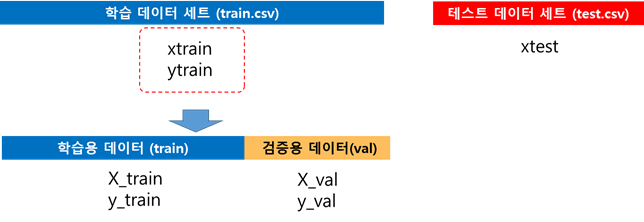

## 학습시킬 feature 선택하기

In [90]:
from sklearn.model_selection import train_test_split 
train_x= train_new.drop(columns=['ID','도시','동']).copy()
train_y= train['ECLO'].copy()

In [91]:
#train data set를 train과 validation data set로 나누기
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=0)

In [92]:
# 데이터 사이즈 확인
print("Size of X_train is:{}\nSize of y_train is:{}\nSize of X_valid is:{}\nSize of y_valid is:{}\n".format(
    X_train.shape,y_train.shape,X_val.shape,y_val.shape))

Size of X_train is:(27726, 86)
Size of y_train is:(27726,)
Size of X_valid is:(11883, 86)
Size of y_valid is:(11883,)



# 모델 구현 - train, validation set

In [93]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [94]:
rf_reg = RandomForestRegressor()
ex_reg = ExtraTreesRegressor()
xgb_reg = XGBRegressor()
lgb_reg = LGBMRegressor()

In [95]:
rf_reg.fit(X_train, y_train)
ex_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgb_reg.fit(X_train, y_train)

LGBMRegressor()

In [96]:
pred_rf=rf_reg.predict(X_val)   #예측 
pred_ex=ex_reg.predict(X_val)   #예측 
pred_xgb=xgb_reg.predict(X_val)   #예측 
pred_lgb=lgb_reg.predict(X_val)   #예측 

In [97]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
#  1. RMSLE 작성
def rmsle(pred, actual):
    log_pred = np.log1p(pred) 
    log_actual = np.log1p(actual)
    squared_error = (log_pred-log_actual)**2   
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
#  2. RMSE 작성
def rmse(pred, actual):
    return np.sqrt(mean_squared_error(pred, actual))
#  3. MAE 작성
def mae(pred, actual):
    return mean_absolute_error(pred, actual)

In [98]:
def evaluate_regr(pred, actual):
    rmsle_val=rmsle(pred, actual)
    rmsl_val=rmse(pred, actual)
    mae_val=mae(pred, actual)
    print('RMSLE: {:.3f}, RMSE: {:.3f}, MAE: {:.3f}'.format(rmsle_val, rmsl_val, mae_val))

In [99]:
evaluate_regr(pred_rf, y_val)  #랜덤포레스트 평가
evaluate_regr(pred_ex, y_val)  #엑스트라트리 평가
evaluate_regr(pred_xgb, y_val) #XGB 평가
evaluate_regr(pred_lgb, y_val) #LGBM 평가

RMSLE: 0.479, RMSE: 3.343, MAE: 2.235
RMSLE: 0.560, RMSE: 3.995, MAE: 2.578
RMSLE: 0.474, RMSE: 3.318, MAE: 2.205
RMSLE: 0.460, RMSE: 3.199, MAE: 2.144


# 모델 적용 - 진짜 test 데이터에 적용
- Decision tree의 검증데이터세트의 정확도가 높으므로 채택!
- lightgbm도 정확도가 높으므로 채택!

## 학습시킬 feature 선택하기
- 위에 검증셋 나눌때 X_train을 다르게 설정했으니까, 다시 설정해주기

In [100]:
# 예측에 모든 컬럼 사용하는 법.
X_test = test_new.drop(columns=['ID','도시','동']).copy()
X_train = train_new[X_test.columns].copy()

In [101]:
y_train = train['ECLO'].copy()

In [102]:
sample_submission = pd.read_csv('open/sample_submission.csv', index_col=0)
sample_submission

,ECLO
ID,
ACCIDENT_39609,0
ACCIDENT_39610,0
ACCIDENT_39611,0
ACCIDENT_39612,0
ACCIDENT_39613,0
...,...
ACCIDENT_50567,0
ACCIDENT_50568,0
ACCIDENT_50569,0


In [103]:
#y_test로 일단 데이터수 확인 위해 설정
y_test = sample_submission['ECLO'].copy()

In [104]:
# 데이터 사이즈 확인
print("Size of X_train is:{}\nSize of y_train is:{}\nSize of X_test is:{}\nSize of y_test is:{}\n".format(
    X_train.shape,y_train.shape,X_test.shape,y_test.shape))

Size of X_train is:(39609, 86)
Size of y_train is:(39609,)
Size of X_test is:(10963, 86)
Size of y_test is:(10963,)



## RandomForestRegressor

In [105]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 1000, 
                             max_depth = 9, 
                             random_state=37, 
                             max_features =0.8, 
                             n_jobs=-1)

In [106]:
rfr.fit(X_train, y_train)

prediction_rfr= rfr.predict(X_test)
prediction_rfr

array([4.09851911, 3.70377855, 5.09318329, ..., 4.77314204, 4.816549  ,
       4.77632854])

In [107]:
### 이거 어제 보여드렸던건데 의미가 없는 것 같아요 - 왜냐면 우리는 y_test의 정답을 모르니까
# 이건 아마 위에 validation set으로 나누었을떄 사용 가능한 거인 거 같아요 
#random forest에서는 점수가 나오는데 lightGBM 적용하면 점수가 안나오네용.. ㅠ

import numpy as np
from sklearn.metrics import make_scorer

def rmsle(predict, actual):
    log_predict= np.log(predict +1)
    log_actual = np.log(actual+1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_score = make_scorer(rmsle)
from sklearn.model_selection import cross_val_score

score = cross_val_score(rfr , X_train, y_train, cv =5, 
                        scoring=rmsle_score).mean()

print('현재 점수는 {0:.5f}'.format(score))



현재 점수는 0.45997


In [108]:
random_forest_submission = sample_submission.copy()
random_forest_submission['ECLO'] = prediction_rfr
random_forest_submission

,ECLO
ID,
ACCIDENT_39609,4.098519
ACCIDENT_39610,3.703779
ACCIDENT_39611,5.093183
ACCIDENT_39612,5.074800
ACCIDENT_39613,4.992524
...,...
ACCIDENT_50567,5.108053
ACCIDENT_50568,4.744571
ACCIDENT_50569,4.773142


In [109]:
prediction_rfr

array([4.09851911, 3.70377855, 5.09318329, ..., 4.77314204, 4.816549  ,
       4.77632854])

In [110]:
random_forest_submission.to_csv('random_forest_submission.csv')

## **Random Forest 대회 제출 결과 점수: 0.4446305641**

----

## Light GBM Regressor

In [111]:
lgb_reg = LGBMRegressor()
lgb_reg.fit(X_train, y_train)
prediction_lgb_reg= lgb_reg.predict(X_test)
prediction_lgb_reg

array([3.96415632, 3.6573477 , 4.9486622 , ..., 4.66916774, 4.66429238,
       4.87572509])

In [112]:
LGBM_submission = sample_submission.copy()
LGBM_submission['ECLO'] = prediction_lgb_reg
LGBM_submission

,ECLO
ID,
ACCIDENT_39609,3.964156
ACCIDENT_39610,3.657348
ACCIDENT_39611,4.948662
ACCIDENT_39612,4.871518
ACCIDENT_39613,4.886757
...,...
ACCIDENT_50567,5.095283
ACCIDENT_50568,4.580975
ACCIDENT_50569,4.669168


In [113]:
#submission 파일로 저장
LGBM_submission.to_csv('LGBM_submission.csv')

## **Light GBM 대회 제출 결과 점수: 0.0.4427601769**

------